<a href="https://www.kaggle.com/code/valerybonneau/ps-s3e24-eda-automl-and-ensemble-models?scriptVersionId=193455010" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Table of content

0. [Introduction](#zero)
1. [Import Libraries and Data](#one)
2. [EDA](#two)
3. [Data Preparation](#three)
4. [Auto Ml test](#four)
5. [Random Forest](#five)
6. [Logistic Regression](#six)
7. [XGBoost](#seven)
8. [CatBoost](#eight)
9. [LightGBM](#nine)
10. [ExtraTreesClassifier](#ten)
11. [HistGradientBoostingClassifier](#eleven)
12. [Neural Network - Scikit and Keras](#twelve)
13. [Ensemble implementation](#thirteen)
14. [Conclusion and Submission](#fourteen)

<a id='#zero'></a>
# 0. Introduction
Second public notebook. I will change quite a lot of things to make it more helpfull for others and also faster.</br>

After a quick look at the data, I guess a solid cross validation strategy and an ensemble model could work fine but I'll adjust while discovering the dataset and talking with others.<br>

A big thanks again to @ambrosm, @adaubas and @oscarm524. Following their advices on PS S3E23 help me quite a lot. I have written when the code was adpated from their code. If it is not clear enough, let me know.

<a id='one'></a>
# 1. Libraries and data import

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Math and data manipulation packages
import numpy as np
import pandas as pd
from scipy.stats import randint, uniform
import scipy.stats as stats

# DataViz packages
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing packages
from sklearn.feature_selection import mutual_info_regression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

from sklearn.preprocessing import PowerTransformer, FunctionTransformer, PolynomialFeatures

# Model packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron

# Neural Network 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Ensemble model build
from sklearn.ensemble import VotingClassifier

# Metrics and optimization
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# Execution tim
import time

sns.set()
# make sure we can see needed columns and rows
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

np.set_printoptions(linewidth=195, edgeitems=5)

force_row_wise=True

In [ ]:
train = pd.read_csv('/kaggle/input/playground-series-s3e24/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e24/test.csv')
train.head(20).T

In [ ]:
train.nunique()

`hearing(left)`, `hearing(right)`, `Urine protein` are categorical ordinal (though hearing has only two values so maybe boolean could fit. I'll see later)<br>
`dental caries` is boolean
all the others are numerical

In [ ]:
train.describe().T

In [ ]:
train.info()

The type seems relevant, there is no NaN. `hearing(left)` (and right) are 97.% equal to 1

<a id='two'></a>
# 2. EDA
I am running classical EDA while searching for ideas, correlation or new ideas to create new features that could improve the results.

In [ ]:
binary = train.drop('id', axis=1)

features = binary.columns.tolist()
features = features[:-1]

In [ ]:
_, axs = plt.subplots(nrows=8, ncols=3, figsize=(12, 36))
for col, ax in zip(binary.columns, axs.ravel()):
    if binary[col].dtype == float:
        ax.hist(binary[col], bins=100, color='red')
    else:
        no_float = binary[col].value_counts()
        ax.bar(no_float.index, no_float, color='red')
    ax.set_title(col)
plt.tight_layout
plt.subplots_adjust(hspace = 0.5)
plt.suptitle('feature description')
plt.show()

Seven features are right skewed. I might apply log transformations. <br> Two features are left skewed, but with outliers on the right side. I'll decide later what to do.

## Correlation matrix

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})
corr = binary.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={'shrink':.5}, annot=True, fmt='.1f')

There seems to be very few correlated values. `waist` and `weight`, `relaxation` and `systolic` are about 0.8 correlated, then few values are around 0.6

## Outliers
There is a lot of outliers (especially on the last quartile). Though it has no impact on tree models, it will have an impact on Neural Network and Logistic Regression. I will create  a function to remove a certain level of outliers and see the output on the results.

In [ ]:
# I decided to sort the features later in the notebook, so I add it here again for clarification. Not optimal, but clearer.
feat_num = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)',
            'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
            'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp']

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12,36))
for col, ax in zip(feat_num, axes.flatten()):
    sns.boxplot(data=binary, x='smoking', y=col, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    plt.tight_layout
plt.subplots_adjust(hspace = 0.5)
plt.suptitle('outliers  for smokers(1) and non smokers(0)')
plt.show()

## Class Distribution
surprisingly, to me, the target is not very imbalanced. I won't look into SMOTE or equivalent.

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(binary, y="smoking");

In [ ]:
(binary['smoking'].value_counts(normalize=True)*100).round(2)

**Creation of X_train and y_train**

In [ ]:
X_train = binary.drop('smoking', axis=1)
y_train = binary['smoking']
X_test = test.drop('id', axis=1)

<a id='three'></a>
# 3. Data transformation on Features
I'll sort features between numerical and categorical (ordinal and cardinal). It is not clear yet if `dental caries` should be ordinal or not. Same with `hearing`

In [ ]:
feat_num = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)',
            'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
            'HDL', 'LDL', 'hemoglobin', 'serum creatinine', 'AST', 'ALT', 'Gtp']

feat_cat = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']


r_skewed = ['fasting blood sugar', 'triglyceride', 'HDL', 'LDL', 'AST', 'ALT', 'Gtp']
l_skewed = ['eyesight(left)', 'eyesight(right)']


## Mutual Information

Mutual Information tells us if there is more or less uncertainty on knowing 'smoking' while knowing the value of a given feature. For instance, knowing `height(cm)` decrease the incertainty while knowing or not `Urine protein` does not seem to change the uncertainty about `smoking`.

In [ ]:
# Adapted from the 'feature engineering' kaggle course: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

features = X_train.columns.tolist

mi_scores = make_mi_scores(X_train, y_train, features)
mi_scores

## Feature Importance
I have used the model with the higher score to see if I could work something out with the feature importance. The result are coherent with the mutual information.
Unfortunately, though I have tried many new features (ratio, sum, difference etc), I coulnt create a single useful new feature.<br>
Removing the useless feature didnt help either.

In [ ]:
# adapted from kaggle course https://www.kaggle.com/code/dansbecker/permutation-importance
import eli5
from eli5.sklearn import PermutationImportance

train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, random_state=1)

lgbm_test = lgb.LGBMClassifier(
            objective='binary', metric='auc',
            num_leaves=24, n_estimators=550,
            learning_rate=.125, max_depth=16,
            min_child_weight=30, min_child_samples=512,
            colsample_bytree=0.5, reg_alpha=12,
            verbose=0,
            random_state=73).fit(train_X, train_y)

perm = PermutationImportance(lgbm_test, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

## Removing Outliers
I will remove outliers only for Logistic Regression and Neural Network as tree models are not supposed to be affected by outliers. I will add the function *remove_outliers* in the pipeline for those models only.

In [ ]:
def remove_outliers(X, y, times_z=4):
    """
    remove the outliers from a df X and the equivalent indexes from a df y.
    
    Args:
        X (dataframe): the dataframe to remove outliers from
        y (dataframe): the dataframe used for training the model and in which rows indexesof X are removed
        times_z: z is the z_score. If times_z is 3, the values that are bigger than 3*z or smaller than -3*z will be removed
        
    Returns:
        X_o, y_o: the dataframes without the outlisers
    """
    z = np.abs(stats.zscore(X))
    mask = (z < times_z).all(axis=1)
    X_o = X[mask]
    y_o = y[mask]
    return X_o, y_o

<a id='four'></a>
# 4. AutoML
I have removed the code as it takes too long but after installation, it is pretty straigthforward:<br>

In [ ]:
# !pip install autogluon > nul

# from autogluon.tabular import TabularDataset, TabularPredictor

# automl = TabularPredictor(
#     problem_type='binary',
#     label='smoking',
#     eval_metric='roc_auc'
# )

# automl.fit(train, presets='best_quality')
# automl.leaderboard()

# predictions = automl.predict(test)

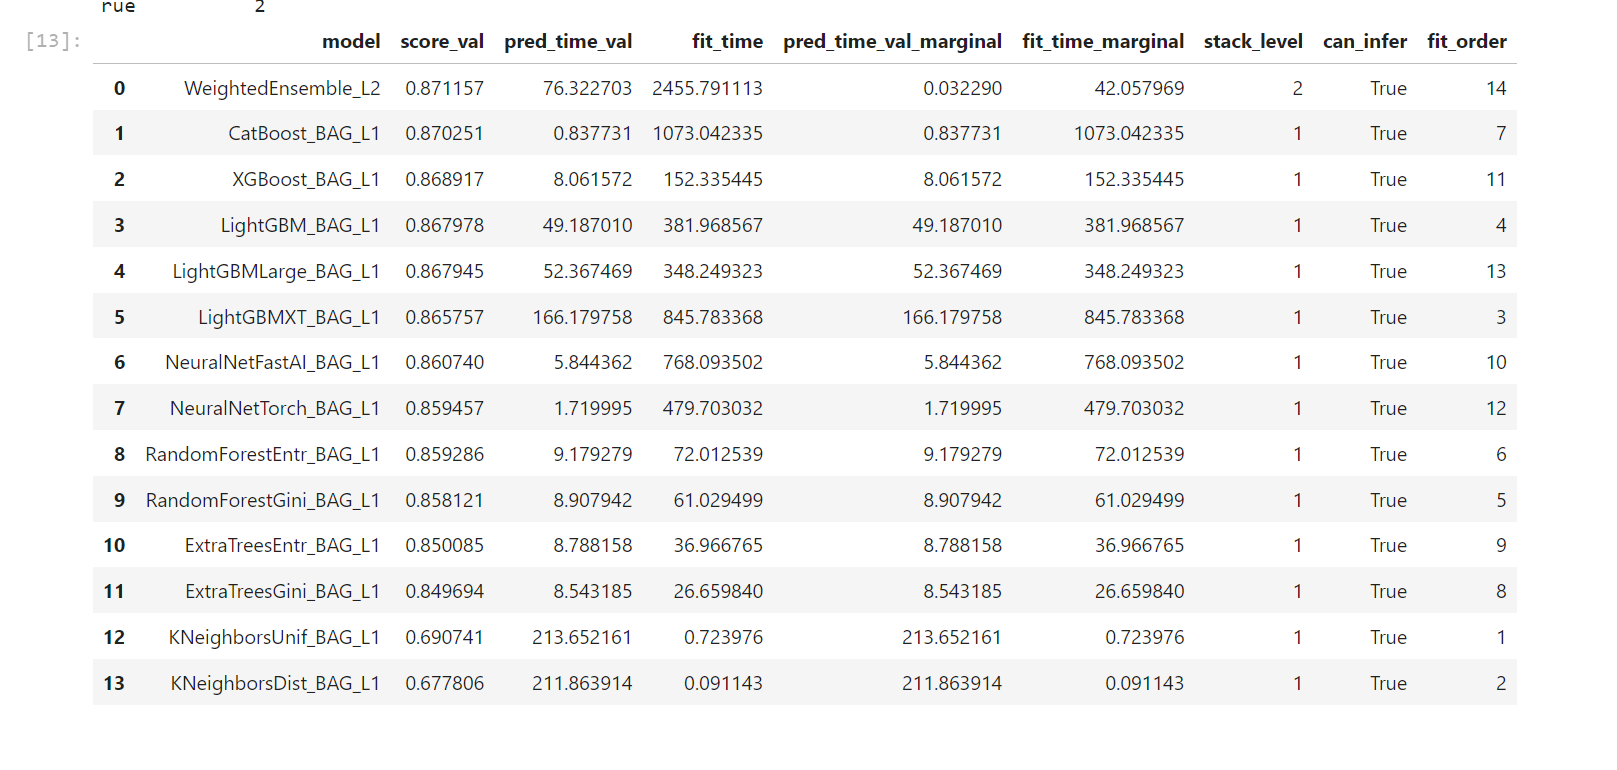

## Cross-validation strategy
I will search manually for the best parmeters for each model using a loop. But I will publish only the best parameters I've found.<br>
Also, in order to avoid overfitting, I will rescale the training set and the skewed features AFTER the folds have been defined within the cross validation function.

In [ ]:
from sklearn.preprocessing import power_transform, MinMaxScaler
def transform_features(X1, X2):
    transformer = FunctionTransformer(np.log1p)
    minmaxscaler = MinMaxScaler()

    X1_s = minmaxscaler.fit_transform(X1)
    X2_s = minmaxscaler.transform(X2)

    X1_s = pd.DataFrame(data=X1_s, columns=X1.columns)
    X2_s = pd.DataFrame(data=X2_s, columns=X2.columns)
    
    X1_s.loc[:, r_skewed] = transformer.fit_transform(X1_s.loc[:, r_skewed])
    X2_s.loc[:, r_skewed] = transformer.transform(X2_s.loc[:, r_skewed])

    X1_s = pd.DataFrame(data=X1_s, columns=X1.columns)
    X2_s = pd.DataFrame(data=X2_s, columns=X2.columns)

    # in case the l_skewed list is empty
    try:
        X1_s.loc[:, l_skewed] = power_transform(X1_s.loc[:, l_skewed], method='yeo-johnson')
        X2_s.loc[:, l_skewed] = power_transform(X2_s.loc[:, l_skewed], method='yeo-johnson')
        X1_s = pd.DataFrame(data=X1_s, columns=X1.columns)
        X2_s = pd.DataFrame(data=X2_s, columns=X2.columns)
    except ValueError:
        return X1_s, X2_s
        
    return X1_s, X2_s

In [ ]:
# adapted from https://www.kaggle.com/code/ambrosm/pss3e23-eda-which-makes-sense
# Thanks a lot to AmbrosM (https://www.kaggle.com/ambrosm)

def cross_val(model, X, y):
    tic = time.time()
       
    kf = StratifiedKFold(shuffle=True, random_state=73)
    
    roc_auc = []
    roc_auc_tr = []

    for fold, (indX_tr, indX_va) in enumerate(kf.split(X, y)):
        X_tr = X.iloc[indX_tr]
        X_va = X.iloc[indX_va]
        y_tr = y.iloc[indX_tr]
        y_va = y.iloc[indX_va]
        
        # removing outliers from the train set only
        X_tr, y_tr = remove_outliers(X_tr, y_tr, times_z=6)
        
        # Applying scaling and left/righ skewed transformation
        X_tr, X_va = transform_features(X_tr, X_va)
        
        model.fit(X_tr, y_tr)
        if hasattr(model, "predict_proba"):
            y_va_pred = model.predict_proba(X_va)[:, 1]
            y_tr_pred = model.predict_proba(X_tr)[:, 1]
        else:
            y_va_pred = model.predict(X_va)
            y_tr_pred = model.predict(X_tr)
            
        roc_auc.append(roc_auc_score(y_va, y_va_pred))
        roc_auc_tr.append(roc_auc_score(y_tr, y_tr_pred))
    roc_auc = np.array(roc_auc).mean()
    roc_auc_tr = np.array(roc_auc_tr).mean()

    
    tac= time.time()
    print(f'training score: {roc_auc_tr}')
    print(f'execution time of {model}: {round((tac-tic),2)} seconds')
    return roc_auc

In [ ]:
def plot_score(scores):
    sns.scatterplot(x=[x for x, y in scores], 
                   y=[y for x,y in scores])
    plt.xscale('linear')
    plt.show()
    print(scores)
    return True

<a id='five'></a>
# 5. Random Forest Testing
As the submission file must contains probabilities and not binary values, RandomForestRegressor seems better than RandomForestClassifier.<br>
I'll test both models anyhow as RandomForestClassifier should work fine with the training set.

In [ ]:
scores=[]
# score = cross_val(
#         RandomForestClassifier(max_features=1.0,
#                                n_estimators=500,
#                                max_depth=8,
#                                n_jobs=-1,
#                                random_state=73,
#                                verbose=0),
#             X_train_s, y_train)
# scores.append(('RandomForestClassifier', score))  

RandomForest performs very poorly (around 0.84) in both cases and it takes ages so I've removed it.

<a id='six'></a>
# 6. Logistic Regression

In [ ]:
# adapted from https://www.kaggle.com/code/ambrosm/pss3e23-eda-which-makes-sense

score = cross_val(make_pipeline(
    StandardScaler(),
    PolynomialFeatures(2, include_bias=False),
    LogisticRegression(solver='newton-cholesky', max_iter=1500)),
    X_train, y_train)
scores.append(('LogisticRegression', score))

<a id='seven'></a>
# 7. XGBoost

In [ ]:
!pip install xgboost > nul

In [ ]:
score = cross_val(
XGBClassifier(
    objective= 'multi:softprob',
    booster='gbtree',
    eval_metric='mlogloss', 
    tree_method='exact',
    num_class=2,
    max_depth=5, 
    n_estimators=350,
    alpha=1.0886723239255782, 
    reg_lambda=7.444528160038042,
#     reg_lambda=2,
    gamma=2.042042140069913, 
    max_leaves=0, 
    subsample=0.7016715426025026,
    colsample_bytree=0.6674195647253229,  
    colsample_bylevel=0.8039230997246618, 
    eta=0.2834927764222458,
    random_state=73,
    n_jobs=-1),
    X_train, y_train)
print(score)
scores.append(('XGBClassifier', score))

<a id='eight'></a>
# 8. CatBoost

In [ ]:
score = cross_val(
    CatBoostClassifier(
    loss_function='Logloss',
    learning_rate=0.0925,
    iterations=1000,
    depth=5,
    l2_leaf_reg=16,
    grow_policy='Lossguide',
    border_count=512,
    random_state=73,
    verbose=0),
        X_train, y_train)
scores.append(('CatBoostClassifier0', score))

In [ ]:
score = cross_val(
    CatBoostClassifier(
            depth=5,
            iterations=250,
            learning_rate=0.5,
            border_count=225,
            grow_policy='SymmetricTree',
            verbose=0,
            random_state=73),
        X_train, y_train)
scores.append(('CatBoostClassifier1', score))


<a id='nine'></a>
# 9. LGBM

In [ ]:
!pip install lightgbm > nul

In [ ]:
score = cross_val(
        lgb.LGBMClassifier(
            objective='binary',
            metric='auc',
            num_leaves=24,
            n_estimators=550,
            learning_rate=.125,
            max_depth=16,
            min_child_weight=30,
            min_child_samples=512,
            colsample_bytree=0.5,
            reg_alpha=12,
            verbose=0,
            random_state=73),
        X_train, y_train)
scores.append(('LGBMClassifier', score))

In [ ]:
score = cross_val(
        lgb.LGBMClassifier(
            objective='binary',
            metric='auc',
            num_leaves=12,
            n_estimators=550,
            learning_rate=.1,
            max_depth=8,
            min_child_weight=30,
            min_child_samples=256,
            colsample_bytree=0.5,
            verbose=0,
            random_state=73),
        X_train, y_train)
scores.append(('LGBMClassifier1', score))

<a id='ten'></a>
# 10. ExtraTreeClassifier

In [ ]:
score = cross_val(
    ExtraTreesClassifier(
        max_depth=100,
        max_features=1.0,
        min_samples_leaf=100,
        n_estimators=250,
        min_samples_split=5,
        bootstrap=False,
        random_state=73,
        verbose=0),
        X_train, y_train)
scores.append(('ExtraTreesClassifier', score))  

<a id='eleven'></a>
# 11. HistGradient

In [ ]:
score = cross_val(
    HistGradientBoostingClassifier(
        max_depth=20,
        max_iter=500,
        learning_rate=0.0125,
        max_leaf_nodes=30,
        l2_regularization=0.1,
        random_state=73,
        verbose=0),
        X_train, y_train)
scores.append(('HistGradientBoostingClassifier', score))  

<a id='twelve'></a>
# 12. Neural Network

In [ ]:
def create_keras_model(optimizer, neurons=256, dropout_rate=0.001):
    model = Sequential()
    model.add(Dense(256, input_dim=22, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.AUC()])
    return model

In [ ]:
score = cross_val(
    KerasClassifier(
        build_fn=create_keras_model, optimizer='adam', neurons=256, dropout_rate=0.001, verbose=0),
    X_train, y_train)
scores.append(('NN', score))

In [ ]:
scores

# BlueCast automl
Following a discussion with Thomas Weiner, I'm trying Bluecast Automl.
I might use it in the ensemble (I wonder if it will work).<br>
You can check his [notebook](https://www.kaggle.com/code/thomasmeiner/ps3e24-bluecast-eda-automl-tracking)

In [ ]:
# !pip install bluecast

In [ ]:
# # adapted from the following notebook: https://www.kaggle.com/code/thomasmeiner/ps3e24-bluecast-eda-automl-tracking
# from bluecast.blueprints.cast import BlueCast

# automl = BlueCast(
#         class_problem="binary",
#         target_column="smoking"
#     )

# automl.fit(train, target_col="smoking")
# y_probs, y_classes = automl.predict(test)

In [ ]:
# # adapted from the following notebook: https://www.kaggle.com/code/thomasmeiner/ps3e24-bluecast-eda-automl-tracking
# from bluecast.blueprints.cast import BlueCast
# from bluecast.blueprints.cast_cv import BlueCastCV
# from bluecast.config.training_config import TrainingConfig, XgboostTuneParamsConfig
# from bluecast.preprocessing.custom import CustomPreprocessing
# from bluecast.general_utils.general_utils import save_to_production, load_for_production
# from bluecast.config.training_config import TrainingConfig

# from sklearn.model_selection import StratifiedKFold, RepeatedKFold


# # custom kfold
# skf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=3000)

# # Create a custom tuning config and adjust hyperparameter search space
# xgboost_param_config = XgboostTuneParamsConfig()
# xgboost_param_config.eta_min = 0.1
# xgboost_param_config.eta_max = 0.3
# xgboost_param_config.max_depth_max = 7

# # Create a custom training config and adjust general training parameters
# train_config = TrainingConfig()
# train_config.global_random_state = 1987
# train_config.hypertuning_cv_folds = 5
# train_config.enable_grid_search_fine_tuning = True # enable param refinement
# train_config.use_full_data_for_final_model = False

# X_train_s, X_test_s = transform_features(X_train, X_test)

# automl = BlueCastCV(
#         class_problem="binary", # also multiclass is possible
#         stratifier=skf,
#         conf_training=train_config,
#         conf_xgboost=xgboost_param_config,
#         #custom_preprocessor=custom_preprocessor,
#         #ml_model=custom_model_tab
#         )

# automl.fit_eval(binary, target_col='smoking')

<a id='thirteen'></a>
# 13. Ensemble

In [ ]:
lr = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(2, include_bias=False),
    LogisticRegression(solver='newton-cholesky', max_iter=1000))
# scores.append(('LogisticRegression', score)) 

# rfc estimator
rfc = RandomForestClassifier(max_features=1.0,
                           random_state=73)

# XGBoost estimator
xgbc = XGBClassifier(
        objective= 'multi:softprob',
        booster='gbtree',
        eval_metric='mlogloss', 
        tree_method='exact',
        num_class=2,
        max_depth=5, 
        n_estimators=350,
        alpha=1.0886723239255782, 
        reg_lambda=7.444528160038042,
        gamma=2.042042140069913, 
        max_leaves=0, 
        subsample=0.7016715426025026,
        colsample_bytree=0.6674195647253229, 
        colsample_bylevel=0.8039230997246618, 
        eta=0.2834927764222458,
        random_state=73,
        n_jobs=-1)


# CatBoost
cbc = CatBoostClassifier(
    loss_function='Logloss',
    learning_rate=0.0925,
    iterations=1000,
    depth=5,
    l2_leaf_reg=16,
    grow_policy='Lossguide',
    border_count=512,
    random_state=73,
    verbose=0)

# LightGBM
lgbm0 = lgb.LGBMClassifier(
            objective='binary',
            metric='auc',
            num_leaves=24,
            n_estimators=550,
            learning_rate=.125,
            max_depth=16,
            min_child_weight=30,
            min_child_samples=512,
            colsample_bytree=0.5,
            reg_alpha=12,
            verbose=0,
            random_state=73)

lgbm1 = lgb.LGBMClassifier(
            objective='binary',
            metric='auc',
            num_leaves=12,
            n_estimators=550,
            learning_rate=.1,
            max_depth=8,
            min_child_weight=30,
            min_child_samples=256,
            colsample_bytree=0.5,
            verbose=0,
            random_state=73)

hgbc = HistGradientBoostingClassifier(
        max_depth=20,
        max_iter=500,
        learning_rate=0.0125,
        max_leaf_nodes=30,
        l2_regularization=0.1,
        random_state=73,
        verbose=0)

etc = ExtraTreesClassifier(
        max_depth=100,
        max_features=1.0,
        min_samples_leaf=100,
        n_estimators=250,
        min_samples_split=5,
        bootstrap=False,
        random_state=73,
        verbose=0)

nn = KerasClassifier(
            build_fn=create_keras_model, optimizer='adam', neurons=256, dropout_rate=0.05, verbose=0)

In [ ]:
nn._estimator_type = "classifier"

estimators =(
    [('lr', lr),
     ('xgbc', xgbc),
     ('cbc', cbc),
     ('lgbm0', lgbm0),
     ('lgbm1', lgbm1),
     ('hgbc', hgbc)])

X_train_s, X_test_s = transform_features(X_train, X_test)

vcl = VotingClassifier(estimators=estimators,
                        weights=[0.75, 3.0, 2.0, 3.5, 2.5, 1.5],
                        voting='soft',
                        n_jobs=-1)
vcl.fit(X_train_s, y_train)
predictions = vcl.predict_proba(X_test_s)

# Conclusion and submission
My initial goal wat to end in the top15% but I finally end in the top 22%.<br>
The thing is I realized my work on the models was not good enough and that I should spend more time on the features engineering. SO I decided to leave that for the next PS!

In [ ]:
output_sample = pd.read_csv('/kaggle/input/playground-series-s3e24/sample_submission.csv')
output = pd.DataFrame({'id': output_sample.id, 'smoking': predictions[:,1]})
output.to_csv('submission.csv', index=False, sep=',')